# Dense & continuous output

One of the peculiar features of Taylor's method is that it directly provides,
via Taylor series, *dense* (or *continuous*) output.
That is, the Taylor series built by the integrator at each timestep can be used
to compute the solution of the ODE system at *any time* within the timestep
(and not only at the endpoint) via polynomial evaluation.

Because the construction of the Taylor series is part of the timestepping algorithm,
support for dense output comes at essentially no extra
cost. Additionally, because the dense output is computed via the
Taylor series of the solution of the ODE system, its accuracy
is guaranteed to respect the error tolerance set in the integrator.

Dense output can be used either from a low-level API, which gives direct access to
the coefficients of the Taylor polynomials of the solution within a timestep,
or from a higher-level API, which facilitates the common use case of using the coefficients
of the Taylor polynomials to compute the continuous extension of the solution.
If you are interested only in the latter, you can skip the next sections and jump
directly to the continuous output section.

In order to illustrate how to use dense output in heyoka.py,
we will keep things simple and consider a simple harmonic oscillator:

$$
   \begin{cases}
   x^\prime = v \\
   v^\prime = -x
   \end{cases},
$$

with initial conditions

$$
   \begin{cases}
   x\left( 0 \right) = 0 \\
   v\left( 0 \right) = 1
   \end{cases}.
$$

The analytical solution for this simple ODE system is, of course,

$$
   \begin{cases}
   x\left( t \right) = \sin\left(t\right) \\
   v\left( t \right) = \cos\left(t\right)
   \end{cases}.
$$

## Dense output for the ``step()`` methods

Let's start by setting up the integrator:

In [1]:
import heyoka as hy
import numpy as np

x, v = hy.make_vars("x", "v")

ta = hy.taylor_adaptive([(x, v),
                         (v, -x)],
                        state = [0, 1])

Enabling dense output in heyoka.py is a two-step process.

The first step is to invoke one of the ``step()`` methods
passing an extra boolean parameter set to ``True``:

In [2]:
ta.step(write_tc = True)

(<taylor_outcome.success: -4294967297>, 1.03425164317259)

The extra ``write_tc = True`` argument instructs the integrator
to record into an internal array the list of Taylor series
coefficients that were generated by the timestepping algorithm.
We can fetch the list of Taylor coefficients
via the ``tc`` read-only property:

In [3]:
ta.tc

array([[ 0.00000000e+00,  1.00000000e+00, -0.00000000e+00,
        -1.66666667e-01,  0.00000000e+00,  8.33333333e-03,
        -0.00000000e+00, -1.98412698e-04,  0.00000000e+00,
         2.75573192e-06, -0.00000000e+00, -2.50521084e-08,
         0.00000000e+00,  1.60590438e-10, -0.00000000e+00,
        -7.64716373e-13,  0.00000000e+00,  2.81145725e-15,
        -0.00000000e+00, -8.22063525e-18,  0.00000000e+00],
       [ 1.00000000e+00, -0.00000000e+00, -5.00000000e-01,
         0.00000000e+00,  4.16666667e-02, -0.00000000e+00,
        -1.38888889e-03,  0.00000000e+00,  2.48015873e-05,
        -0.00000000e+00, -2.75573192e-07,  0.00000000e+00,
         2.08767570e-09, -0.00000000e+00, -1.14707456e-11,
         0.00000000e+00,  4.77947733e-14, -0.00000000e+00,
        -1.56192070e-16,  0.00000000e+00,  4.11031762e-19]])

The Taylor coefficients are stored in a 2D array, where each row refers to a different state variable and the number of columns is the Taylor order of the integrator plus one. Thus, the zero-order coefficients for the $x$ and $v$ variables are, respectively:

In [4]:
ta.tc[:, 0]

array([0., 1.])

Indeed, the zero-order Taylor coefficients for the state variables are nothing but
the initial conditions at the beginning of the timestep that was just taken.

> **NOTE:** This last point is important and needs to be stressed again: the Taylor
> coefficients always refer to the **last** step taken and **not** to the next
> step that the integrator might take.

We are now ready to ask the integrator to compute the value of the solution at some
arbitrary time. Let's pick $t = 0.5$,
which is about halfway through the timestep that was just taken:

In [5]:
ta.update_d_output(t = 0.5)

array([0.47942554, 0.87758256])

The ``update_d_output()`` method takes in input an *absolute* time coordinate
and returns a reference to an internal array that will contain the state of the system
at the specified time coordinate, as computed by the evaluation of the Taylor series.
``update_d_output()`` can also be called with a time coordinate relative to the current time
by passing ``rel_time = True`` as an additional function argument.

The dense output array can be accessed directly via the ``d_output`` property:

In [6]:
ta.d_output

array([0.47942554, 0.87758256])

Let's now compare the dense output for the $x$ variable to the exact analytical solution for $t \in \left[ 0, 1 \right]$:

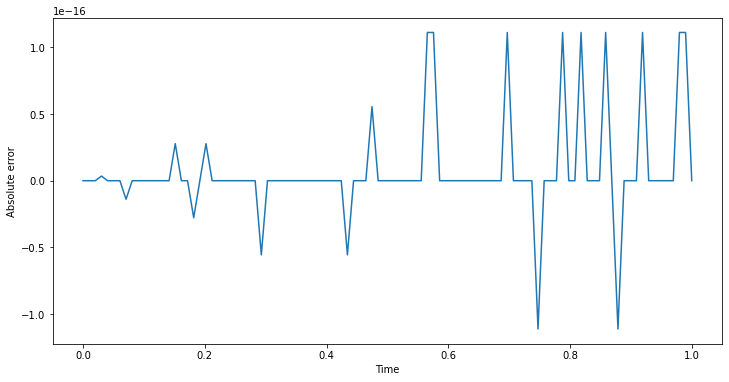

In [7]:
from matplotlib.pylab import plt
plt.rcParams["figure.figsize"] = (12,6)

# Construct a time grid from t=0 to t=1.
t_grid = np.linspace(0, 1, 100)

# Compute the dense output for the x variable
# over the time grid.
x_d_out = np.array([ta.update_d_output(t)[0] for t in t_grid])

# Compare it to the exact solution.
plt.plot(t_grid, (x_d_out - np.sin(t_grid)))
plt.xlabel("Time")
plt.ylabel("Absolute error");

As you can see, the dense output matches the exact solution to machine precision.

Let's now ask for the dense output at the very end of the timestep that was just taken (i.e., at the current time coordinate), and let's compare it to the current state vector:

In [8]:
ta.update_d_output(ta.time) - ta.state

array([0., 0.])

That is, as expected, the dense output at the end of the previous timestep
matches the current state of the system to machine precision.

Before concluding, we need to highlight a couple of caveats regarding the
use of dense output.

> **NOTE**: first, it is the user's responsibility to ensure that the array of Taylor
> coefficients contains up-to-date values. In other words, the user needs to remember
> to invoke the ``step()`` methods with the extra boolean argument ``write_tc = True``
> before invoking ``update_d_output()``.
> Failure to do so will result in ``update_d_output()`` producing incorrect values.

> **NOTE**: second, the accuracy of dense output is guaranteed to match the integrator's
> accuracy only if the time coordinate falls within the last step taken. Note that heyoka.py will
> **not** prevent the invocation of ``update_d_output()`` with time coordinates outside the
> guaranteed accuracy range - it is the user's responsibility to be aware
> that doing so will produce results whose accuracy does not match the integrator's
> error tolerance.

The second point can be better appreciated if we try to compute the dense output past the end of the last timestep taken:

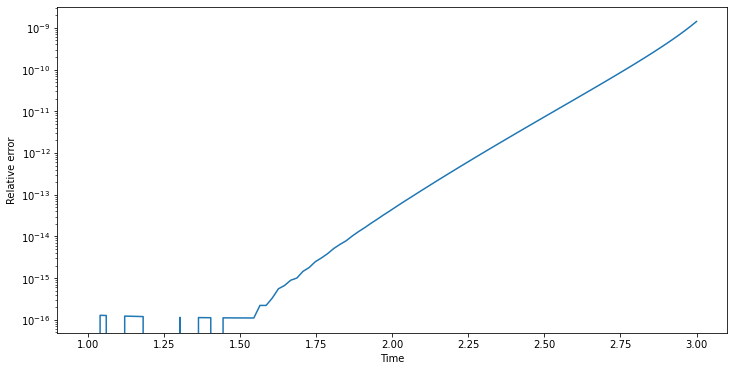

In [9]:
# Construct a time grid from t=1 to t=3.
t_grid = np.linspace(1, 3, 100)

# Compute the dense output for the x variable
# over the time grid.
x_d_out = np.array([ta.update_d_output(t)[0] for t in t_grid])

# Compare it to the exact solution.
plt.semilogy(t_grid, abs((x_d_out - np.sin(t_grid)) / np.sin(t_grid)))
plt.xlabel("Time")
plt.ylabel("Relative error");

As you can see, past $t \sim 1$ the dense output is still accurate for another $\sim 0.5$ time units, but eventually the error with respect to the exact solution begins to increase steadily.

## Dense output for the ``propagate_*()`` methods

Dense output can be enabled also for the time-limited propagation methods
``propagate_for()`` and ``propagate_until()`` via the boolean keyword argument
``write_tc``.

When ``write_tc`` is set to ``True``, the ``propagate_*()`` methods
will internally invoke the ``step()`` methods with the optional boolean
flag ``write_tc`` set to ``True``, so that at the end of each timestep the Taylor coefficients
will be available. The Taylor coefficients can be used, e.g., inside the
optional callback that can be passed to the ``propagate_*()`` methods.

Note that ``propagate_grid()`` always unconditionally writes the Taylor coefficients
at the end of each timestep, and thus using the ``write_tc`` argument is not necessary.

## Continuous output

Starting with heyoka.py 0.16,
the ``propagate_for()`` and ``propagate_until()`` methods can optionally return a function object
providing continuous output in the integration interval. That is, this function object can be used
to compute the solution at any time within the time interval covered by ``propagate_for/until()``.

Continuous output is activated by passing the ``c_output = True`` keyword option to the ``propagate_for/until()`` methods.
Let us see an example:

In [10]:
# Reset the integrator state.
ta.state[:] = [0, 1]
ta.time = 0

# Propagate and return the continuous output.
c_out = ta.propagate_until(10., c_output=True)[4]

The continuous output function object is the fifth element of the tuple returned by ``propagate_for/until()`` (note that if ``c_output`` is set to ``False`` - the default - then the fifth element of the tuple is ``None``).

Let us print ``c_out`` to screen:

In [11]:
c_out

Direction : forward
Time range: [0, 10)
N of steps: 10

The screen output informs us that the ``c_out`` object is capable of providing continuous output in
the $\left[0, 10\right)$ time interval, and that 10 steps were taken during the integration.

The call operator of the ``c_out`` object accepts in input either

* a single absolute time coordinate, or
* a 1D vector of absolute time coordinates.

In the first case, the return value will be a 1D NumPy array containing the state vector at the desired time. In the second case, the return value will be a 2D NumPy array in which each row contains the state vector at the corresponding input time.

Let us see a couple of examples:

In [12]:
# Print the state vector at t = 5.
print("State vector at t=5: {}\n".format(c_out(5.)))

# Print the state vectors at a few different times.
print("State vectors at t=[1,2,3,4,5]:\n{}\n".format(c_out([1,2,3,4,5])))

State vector at t=5: [-0.95892427  0.28366219]

State vectors at t=[1,2,3,4,5]:
[[ 0.84147098  0.54030231]
 [ 0.90929743 -0.41614684]
 [ 0.14112001 -0.9899925 ]
 [-0.7568025  -0.65364362]
 [-0.95892427  0.28366219]]



Let us test the precision of the continuous output over a fine time grid in the $\left[0, 10\right]$ time interval:

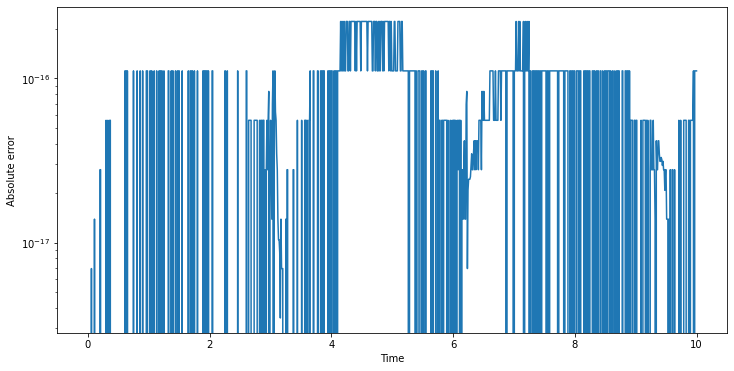

In [13]:
# Construct a time grid from t=0 to t=10.
t_grid = np.linspace(0, 10, 1000)

# Compute the continuous output for the x variable
# over the time grid.
x_c_out = c_out(t_grid)

# Compare it to the exact solution.
plt.semilogy(t_grid, abs(x_c_out[:,0] - np.sin(t_grid)))
plt.xlabel("Time")
plt.ylabel("Absolute error");

As we can see, the continuous output agrees with the analytical solution to machine precision.

Continuous output is somewhat similar to ``propagate_grid()``, in the sense that both allow to compute the value of the solution at arbitrary time points. ``propagate_grid()`` is computationally more efficient, but it requires to specify up-front the list of times at which the solution should be computed. Continuous output, on the other hand, is not bound to a predetermined time grid, and it can thus be helpful if time coordinates of interest can be identified only after the solution has been computed.

Before concluding, we need to highlight a couple of caveats regarding the
use of continuous output.

> **NOTE**: the ``continuous_output`` function object stores internally the time
> coordinate and Taylor coefficients at the end of each step taken during the integration interval.
> This means that the memory usage of a ``continuous_output`` object scales linearly
> with the number of timesteps taken during the integration interval. Thus, for a sufficiently
> long integration interval, the ``continuous_output`` object might end up exhausting the available memory.

> **NOTE**: like for dense output, the accuracy of ``continuous_output`` is guaranteed to
> match the integrator’s accuracy only if the time coordinate falls within the integration interval.
> Note that heyoka.py will not prevent the use of a ``continuous_output`` object outside the
> guaranteed accuracy range - it is the user’s responsibility to be aware that doing so will
> produce results whose accuracy does not match the integrator’s error tolerance.

Note that, like the other main classes in heyoka.py, ``continuous_output`` supports [serialisation](<./pickling.ipynb>).